In [1]:
import os
import yaml
import json
import datetime
import logging
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langgraph.graph import StateGraph, END
from langchain_community.document_loaders import WebBaseLoader
from langchain_google_community import GoogleSearchAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langchain_community.document_loaders import YoutubeLoader
from datetime import datetime, timedelta
from IPython.display import Image, display

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Search Queries
SEARCH_QUERIES = [
    "High-level overview of intelligent user interfaces and their impact on modern UI/UX design",
    "Tools and frameworks for building intelligent user interfaces: A 2024 guide"
]

# Specific Questions
SPECIFIC_QUESTIONS = [
    "What are the latest trends in intelligent user interfaces, and how are they shaping user experience?",
    "What are the best practices for ensuring accessibility and inclusivity in AI-powered user interfaces?",
]

# Time Horizon in days
TIME_HORIZON = 185  # In days

# Max Outputs
MAX_OUTPUTS = 5

PLATFORM = 'google'

# LLM Name
LLM_NAME = "ollama"  # Available options: "ollama", "groq"

# Logger Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
from src.llm import get_llm, get_llm_json_mode

# Initialize LLM
llm = get_llm(LLM_NAME)
llm_json_mode = get_llm_json_mode(LLM_NAME)


In [5]:
# Save configuration data
config_data = {
    "search_queries": SEARCH_QUERIES,
    "specific_questions": SPECIFIC_QUESTIONS,
    "platform": PLATFORM,
    "time_horizon": TIME_HORIZON,
    "max_outputs": MAX_OUTPUTS,
    "llm_name": LLM_NAME,
}


In [6]:
def get_platform_functions(platform, time_horizon):
    if platform == "google":
        # Check API keys
        if not os.getenv("GOOGLE_API_KEY") or not os.getenv("GOOGLE_CSE_ID"):
            raise EnvironmentError("Missing GOOGLE_API_KEY or GOOGLE_CSE_ID environment variables.")

        # Functions for Google
        search = GoogleSearchAPIWrapper()
        def google_top_results(query, SOURCES_PER_QUERY=10):
            return search.results(query, SOURCES_PER_QUERY, search_params={'dateRestrict': f'd{time_horizon}', 'gl':'EN'})

        def google_get_content(urls):
            docs = [WebBaseLoader(url).load() for url in urls]
            docs_list = [item for sublist in docs for item in sublist]
            return docs_list

        platform_functions = {
            "search": google_top_results,
            "get_content": google_get_content,
        }

    elif platform == "youtube":
        # Functions for YouTube
        def youtube_top_results(query, SOURCES_PER_QUERY=10):
            tool = YouTubeSearchTool()
            results = tool.run(f"{query}, {2*SOURCES_PER_QUERY}")
            # Filtering by publishedAt
            filtered_results = []
            for item in results:
                # Assuming item['publishedAt'] is the publication date in ISO 8601 format
                published_date = datetime.strptime(item['publishedAt'], '%Y-%m-%dT%H:%M:%SZ')
                if datetime.now() - published_date <= timedelta(days=time_horizon):
                    filtered_results.append(item)
            return filtered_results[:SOURCES_PER_QUERY]

        def youtube_get_content(urls):
            docs = []
            for url in urls:
                loader = YoutubeLoader.from_youtube_url(
                    url, add_video_info=True
                )
                docs.extend(loader.load())
            return docs

        platform_functions = {
            "search": youtube_top_results,
            "get_content": youtube_get_content,
        }

    else:
        raise ValueError(f"Unknown platform: {platform}")

    return platform_functions

# Get platform functions
platform_functions = get_platform_functions(PLATFORM, TIME_HORIZON)


INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


## Control Flow

### Tracing 

Optionally, use [LangSmith](https://www.langchain.com/langsmith) for tracing. 

In [7]:
import os

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

### Nodes

In [8]:

def google_retrieve_urls(state):
    logger = state["logger"]
    search_queries = state["search_queries"]
    platform_functions = state["platform_functions"]
    unique_urls = set()

    search_func = platform_functions["search"]
    for search_query in search_queries:
        results = search_func(search_query)
        urls = [item['link'] for item in results]
        unique_urls.update(urls)

    state["unique_urls"] = list(unique_urls)
    print(state["unique_urls"])
    logger.info(f"Retrieved {len(unique_urls)} unique URLs from Google.")
    return state

def youtube_retrieve_urls(state):
    logger = state["logger"]
    search_queries = state["search_queries"]
    platform_functions = state["platform_functions"]
    unique_urls = set()

    search_func = platform_functions["search"]
    for search_query in search_queries:
        results = search_func(search_query)
        urls = [item['url'] for item in results]
        unique_urls.update(urls)

    state["unique_urls"] = list(unique_urls)
    logger.info(f"Retrieved {len(unique_urls)} unique URLs from YouTube.")
    return state

def google_process_content(state):
    logger = state["logger"]
    unique_urls = state["unique_urls"]
    platform_functions = state["platform_functions"]
    get_content_func = platform_functions["get_content"]
    docs = get_content_func(unique_urls)
    print(docs)
    state["all_docs"] = docs
    logger.info(f"Processed content from {len(docs)} Google documents.")
    return state

def youtube_process_content(state):
    logger = state["logger"]
    unique_urls = state["unique_urls"]
    platform_functions = state["platform_functions"]
    get_content_func = platform_functions["get_content"]
    docs = get_content_func(unique_urls)
    state["all_docs"] = docs
    logger.info(f"Processed content from {len(docs)} YouTube videos.")
    return state


In [9]:
def create_embeddings(state):
    logger = state["logger"]
    all_docs = state["all_docs"]
    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=1000, chunk_overlap=200
    )
    doc_splits = text_splitter.split_documents(all_docs)
    # Add source information to each chunk
    for doc in doc_splits:
        doc.metadata['source'] = doc.metadata.get('source', 'unknown')

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local", device="nvidia"),
    )
    retriever = vectorstore.as_retriever(search_kwargs={'k': 5})
    state["retriever"] = retriever
    logger.info("Created embeddings for documents.")
    return state

def semantic_search_and_grading(state):
    logger = state["logger"]
    retriever = state["retriever"]
    specific_questions = state["specific_questions"]
    llm_json_mode = state["llm_json_mode"]
    relevant_chunks = {}
    for question in specific_questions:
        docs = retriever.invoke(question)
        for doc in docs:
            doc_txt = doc.page_content
            # Instructions for document grader
            doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""
            # Grader prompt
            doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

Carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' to indicate whether the document contains at least some information that is relevant to the question."""
            doc_grader_prompt_formatted = doc_grader_prompt.format(
                document=doc_txt, question=question
            )
            result = llm_json_mode.invoke(
                [SystemMessage(content=doc_grader_instructions)]
                + [HumanMessage(content=doc_grader_prompt_formatted)]
            )
            grade = json.loads(result.content)["binary_score"]
            if grade.lower() == "yes":
                source = doc.metadata.get('source', 'unknown')
                if source not in relevant_chunks:
                    relevant_chunks[source] = {}
                if question not in relevant_chunks[source]:
                    relevant_chunks[source][question] = []
                relevant_chunks[source][question].append(doc)
    state["relevant_chunks"] = relevant_chunks
    logger.info("Performed semantic search and grading.")
    return state

def generate_qa(state):
    logger = state["logger"]
    relevant_chunks = state["relevant_chunks"]
    llm = state["llm"]
    qa_results = {}
    for source, questions_docs in relevant_chunks.items():
        qa_results[source] = {}
        for question, docs in questions_docs.items():
            context = "\n\n".join(doc.page_content for doc in docs)
            # Prompt for generating answer
            rag_prompt = """You are an assistant for question-answering tasks.

Here is the context to use to answer the question:

{context}

Think carefully about the above context.

Now, review the user question:

{question}

Provide an answer to this question using only the above context.

Use three sentences maximum and keep the answer concise.

Answer:"""
            rag_prompt_formatted = rag_prompt.format(context=context, question=question)
            generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
            qa_results[source][question] = generation.content
    state["qa_results"] = qa_results
    logger.info("Generated Q&A for sources.")
    return state

def hallucination_check(state):
    logger = state["logger"]
    qa_results = state["qa_results"]
    llm_json_mode = state["llm_json_mode"]
    relevant_chunks = state["relevant_chunks"]
    valid_qa_results = {}
    for source, questions_answers in qa_results.items():
        valid_qa_results[source] = {}
        for question, answer in questions_answers.items():
            documents = "\n\n".join(doc.page_content for doc in relevant_chunks[source][question])
            # Instructions for hallucination grader
            hallucination_grader_instructions = """

You are a teacher grading a quiz.

You will be given FACTS and a STUDENT ANSWER.

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS.

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of 'yes' means that the student's answer meets all of the criteria. This is the highest (best) score.

A score of 'no' means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct.

Avoid simply stating the correct answer at the outset."""
            # Grader prompt
            hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}.

Return JSON with two keys: 'binary_score', which is 'yes' or 'no' to indicate whether the STUDENT ANSWER is grounded in the FACTS; and 'explanation', which contains an explanation of the score."""
            hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(
                documents=documents,
                generation=answer
            )
            result = llm_json_mode.invoke(
                [SystemMessage(content=hallucination_grader_instructions)]
                + [HumanMessage(content=hallucination_grader_prompt_formatted)]
            )
            grade = json.loads(result.content)["binary_score"]
            if grade.lower() == "yes":
                valid_qa_results[source][question] = answer
    state["valid_qa_results"] = valid_qa_results
    logger.info("Performed hallucination check.")
    return state

def generate_summaries(state):
    logger = state["logger"]
    all_docs = state["all_docs"]
    llm = state["llm"]
    summaries = {}
    for doc in all_docs:
        source = doc.metadata.get('source', 'unknown')
        if source not in summaries:
            summaries[source] = {}
        content_length = len(doc.page_content)
        if content_length > 7500:
            # Generate detailed hierarchical summary
            summary_prompt = """Please provide a detailed hierarchical summary of the following content:

{content}

The summary should capture all the key points and structure of the content."""
            summary_prompt_formatted = summary_prompt.format(content=doc.page_content)
            summary = llm.invoke([HumanMessage(content=summary_prompt_formatted)])
            summaries[source]["detailed_summary"] = summary.content
        else:
            summaries[source]["content"] = doc.page_content

        # Generate one-sentence summary
        one_sentence_summary_prompt = """Please summarize the following content in one sentence:

{content}

Summary:"""
        one_sentence_summary_prompt_formatted = one_sentence_summary_prompt.format(content=doc.page_content)
        one_sentence_summary = llm.invoke([HumanMessage(content=one_sentence_summary_prompt_formatted)])
        summaries[source]["one_sentence_summary"] = one_sentence_summary.content

    state["summaries"] = summaries
    logger.info("Generated summaries for sources.")
    return state

def rank_sources(state):
    logger = state["logger"]
    valid_qa_results = state["valid_qa_results"]
    # Rank sources based on the number of correctly answered questions
    source_scores = {}
    for source, questions_answers in valid_qa_results.items():
        source_scores[source] = len(questions_answers)
    sorted_sources = sorted(source_scores.items(), key=lambda item: item[1], reverse=True)
    state["sorted_sources"] = sorted_sources
    logger.info("Ranked sources.")
    return state

def save_output(state):
    logger = state["logger"]
    sorted_sources = state["sorted_sources"]
    valid_qa_results = state["valid_qa_results"]
    summaries = state["summaries"]
    max_outputs = state["max_outputs"]

    # Get current time for output folder name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_folder = f"output_{timestamp}"
    os.makedirs(output_folder, exist_ok=True)

    # Save configuration data
    with open(os.path.join(output_folder, "config.yaml"), "w") as f:
        yaml.dump(config_data, f)

    best_sources = {}
    rest_sources = {}

    for idx, (source, score) in enumerate(sorted_sources):
        source_data = {
            "url": source,
            "one_sentence_summary": summaries.get(source, {}).get("one_sentence_summary", ""),
            "summary": summaries.get(source, {}).get("detailed_summary", ""),
            "content": summaries.get(source, {}).get("content", ""),
            "Q&A": valid_qa_results.get(source, {}),
        }
        if idx < max_outputs:
            best_sources[source] = source_data
        else:
            rest_sources[source] = source_data

    # Save best sources
    with open(os.path.join(output_folder, "best_sources.yaml"), "w") as f:
        yaml.dump(best_sources, f, allow_unicode=True)

    # Save rest of the sources
    with open(os.path.join(output_folder, "rest_sources.yaml"), "w") as f:
        yaml.dump(rest_sources, f, allow_unicode=True)

    # Log saving results
    logger.info("Saved results to output folder.")
    return state

In [10]:
### Edges

def route_platform(state):
    """
    Route to the appropriate platform-specific nodes

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    if state["platform"].lower() == 'google':
        return "google_retrieve_urls"
    elif state["platform"].lower() == 'youtube':
        return "youtube_retrieve_urls"
    else:
        raise ValueError("Invalid platform specified in state.")


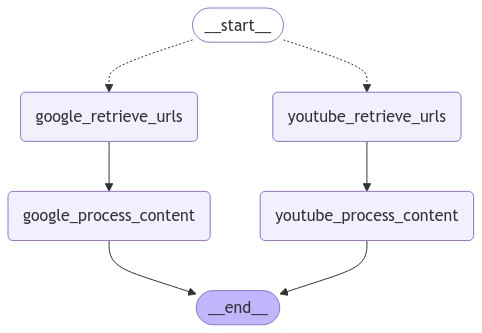

In [11]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated


class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, 
    and modify in, each graph node.
    """

    search_queries: List[str]  # List of search queries for the platform
    specific_questions: List[str]  # List of specific questions for content filtering
    platform: str  # Selected platform, e.g., 'google' or 'youtube'
    platform_functions: dict  # Functions for platform-specific operations (search, get content)
    llm: object  # LLM instance for text generation
    llm_json_mode: object  # LLM instance for JSON-based output generation
    time_horizon: int  # Time horizon in days for filtering content
    max_outputs: int  # Maximum number of outputs to retrieve
    logger: object  # Logger object to track progress
    loop_step: Annotated[int, operator.add]  # Loop counter for controlling retries or iterations
    unique_urls: List[str]  # List of unique URLs retrieved from the platform
    all_docs: List[str]  # List of documents/content retrieved from URLs
    retriever: object  # Retriever object for semantic search
    relevant_chunks: dict  # Relevant content chunks based on questions
    qa_results: dict  # Q&A results after processing content
    valid_qa_results: dict  # Validated Q&A results without hallucinations
    summaries: dict  # Summaries for the processed sources
    sorted_sources: List[str]  # Sources ranked based on relevance to questions
    output_folder: str  # Folder path for saving results

# Define the workflow graph
workflow = StateGraph(GraphState)

# Add nodes
workflow.add_node("google_retrieve_urls", google_retrieve_urls)
workflow.add_node("youtube_retrieve_urls", youtube_retrieve_urls)
workflow.add_node("google_process_content", google_process_content)
workflow.add_node("youtube_process_content", youtube_process_content)
# workflow.add_node("create_embeddings", create_embeddings)
# workflow.add_node("semantic_search_and_grading", semantic_search_and_grading)
# workflow.add_node("generate_qa", generate_qa)
# workflow.add_node("hallucination_check", hallucination_check)
# workflow.add_node("generate_summaries", generate_summaries)
# workflow.add_node("rank_sources", rank_sources)
# workflow.add_node("save_output", save_output)

# Define edges
workflow.set_conditional_entry_point(
    route_platform,
    {
        "google_retrieve_urls": "google_retrieve_urls",
        "youtube_retrieve_urls": "youtube_retrieve_urls",
    },
)

# Platform-specific flows
workflow.add_edge("google_retrieve_urls", "google_process_content")
workflow.add_edge("youtube_retrieve_urls", "youtube_process_content")

# Merge flows after platform-specific processing
workflow.add_edge("google_process_content", END)
workflow.add_edge("youtube_process_content", END)

# # Continue common flow
# workflow.add_edge("create_embeddings", "semantic_search_and_grading")
# workflow.add_edge("semantic_search_and_grading", "generate_qa")
# workflow.add_edge("generate_qa", "hallucination_check")
# workflow.add_edge("hallucination_check", "generate_summaries")
# workflow.add_edge("generate_summaries", "rank_sources")
# workflow.add_edge("rank_sources", "save_output")
# workflow.add_edge("save_output", END)

# Compile the graph
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


# Run the Graph

In [12]:
# Execute the graph
initial_state = GraphState({
    "search_queries": SEARCH_QUERIES,
    "specific_questions": SPECIFIC_QUESTIONS,
    "platform": PLATFORM,
    "platform_functions": platform_functions,
    "llm": llm,
    "llm_json_mode": llm_json_mode,
    "time_horizon": TIME_HORIZON,
    "max_outputs": MAX_OUTPUTS,
    "logger": logger,
})


In [13]:

for event in graph.stream(initial_state, stream_mode="values"):
    print(event)

{'search_queries': ['High-level overview of intelligent user interfaces and their impact on modern UI/UX design', 'Tools and frameworks for building intelligent user interfaces: A 2024 guide'], 'specific_questions': ['What are the latest trends in intelligent user interfaces, and how are they shaping user experience?', 'What are the best practices for ensuring accessibility and inclusivity in AI-powered user interfaces?'], 'platform': 'google', 'platform_functions': {'search': <function get_platform_functions.<locals>.google_top_results at 0x7a077412de40>, 'get_content': <function get_platform_functions.<locals>.google_get_content at 0x7a077412df80>}, 'llm': ChatOllama(model='llama3.2:latest', temperature=0.0), 'llm_json_mode': ChatOllama(model='llama3.2:latest', temperature=0.0, format='json'), 'time_horizon': 185, 'max_outputs': 5, 'logger': <Logger __main__ (INFO)>, 'loop_step': 0}


INFO:__main__:Retrieved 20 unique URLs from Google.


['https://www.ibm.com/products/watsonx-ai', 'https://www.functionize.com/automated-testing/gui-testing-tools', 'https://www.restack.io/p/custom-ai-development-tool-trials-2024-answer-ai-development-flutter-pdf-cat-ai', 'https://link.springer.com/article/10.1007/s11257-024-09414-0', 'https://iui.acm.org/2024/companion_proceedings.html', 'https://ux4sight.com/blog/designing-a-good-user-interface-and-why-its-vital-for-business', 'https://www.codica.com/blog/ai-tech-stack-complete-guide/', 'https://www.reddit.com/r/ycombinator/comments/1e5lumd/why_is_no_one_going_after_the_bloomberg_terminal/', 'https://cacm.acm.org/blogcacm/the-evolution-of-user-interface-design/', 'https://techhub.asia/hire-ui-ux-designer/', 'https://iui.acm.org/2024/proceedings.html', 'https://standards.ieee.org/initiatives/autonomous-intelligence-systems/standards/', 'https://www.linkedin.com/pulse/from-concept-clicks-optimising-uxui-ai-infused-design-james-griffin-zpizf', 'https://www.linkedin.com/pulse/building-intel

INFO:__main__:Processed content from 20 Google documents.


[Document(metadata={'source': 'https://www.ibm.com/products/watsonx-ai', 'title': 'IBM watsonx.ai ', 'description': 'Build in our new studio for foundation models, generative AI and machine learning with watsonx.ai.', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\nIBM watsonx.ai \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nHome\n\n\n\n\nAI and ML\n\n\n\n\nwatsonx\n\n\n\nwatsonx.ai\n\n\n\n\n\n\nwatsonx.ai\n\n\n\n\n\n \n\n\n  \n  \n      Now available—a next generation enterprise studio for AI builders to train, validate, tune and deploy AI models\n  \n\n\n\n\n    \n\n\n\n\n\nStart your free trial \n\n\nExplore the Interactive Demo\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nNew model\n\nMeta Llama 3.2 models now available on\xa0watsonx.\n\n\nRead the blog\n\n\n\n\n\n\n\n\n\n  \n\n\n\n    Our next-generation enterprise studio for AI builders\n\n\n\n\n\n    \

In [14]:
# Review Results
print("Best Sources:")
with open(os.path.join(final_state["output_folder"], "best_sources.yaml"), "r") as f:
    best_sources = yaml.safe_load(f)
    print(yaml.dump(best_sources, allow_unicode=True))

print("\nRest of the Sources:")
with open(os.path.join(final_state["output_folder"], "rest_sources.yaml"), "r") as f:
    rest_sources = yaml.safe_load(f)
    print(yaml.dump(rest_sources, allow_unicode=True))


Best Sources:


NameError: name 'final_state' is not defined